# Project 1: Image Filtering and Hybrid Images

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import sys
import skimage #scikit-learn image manipulation #
from skimage import io
from skimage import data
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt #plot utilities #
import numpy as np #numerical computations #
from mpl_toolkits.mplot3d import Axes3D
import cv2
import scipy
import time

# Analysis in Frequency domain

The following contains function which takes images and converts to Fourier domain.

In [2]:
# all analysis of fft
def fourierT(Img_1,Img_2):
    F_cat = np.fft.fft2(Img_1)
    F_dog = np.fft.fft2(Img_2)

    F_shift_cat = np.fft.fftshift(F_cat)
    F_shift_dog = np.fft.fftshift(F_dog)

    return F_shift_cat,F_shift_dog

Following cell contains a function that generates Gaussian filters (both high pass and low pass).

In [3]:
# gaussian meshdrid of image size
def gauss(sigma,mu,m,n):

    x, y = np.meshgrid(np.linspace(-1,1,n), np.linspace(-1,1,m))
    d = np.sqrt(x*x+y*y)

    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

    h = 1 - g
    return g,h

The following function takes two images and high pass and low pass filters and converts the images into hybrid images.

In [4]:
# for filtering
def hybrid(Img_mag1,Img_mag2,g,h):
    cat_mag_multiplied = np.multiply(Img_mag1,g)
    dog_mag_multiplied = np.multiply(Img_mag2,h)
 
    mag_filtered = cat_mag_multiplied + dog_mag_multiplied
   
    FCT2 = np.fft.ifftshift(mag_filtered)
    hybrid_img = np.real(np.fft.ifft2(FCT2))

    FCT22 = np.fft.ifftshift(cat_mag_multiplied)
    hybrid_img22 = np.real(np.fft.ifft2(FCT22))
    
    FCT23 = np.fft.ifftshift(dog_mag_multiplied)
    hybrid_img23 = np.real(np.fft.ifft2(FCT23))
    
    return hybrid_img,hybrid_img22,hybrid_img23

This function gives final output of the frequency domain analysis of hybrid imaging.

In [5]:
def Fdomain(Img_cat,Img_dog,sigma,label,mu):

    
    #test image


    # need if else here for rgb or gray selection
    if label == "gray":
        m,n = Img_cat.shape
        g,h = gauss(sigma,mu,m,n)

        F_shift_cat,F_shift_dog = fourierT(Img_cat,Img_dog)

        mult1 = F_shift_cat*g
        mult2 = F_shift_dog*h
        mult = mult1 + mult2
        FCT2 = np.fft.ifftshift(mult)
        hybrid_img2 = np.real(np.fft.ifft2(FCT2))
    #     plt.imshow(hybrid_img2,cmap='gray')

    elif label == "color":
        m,n,pp = Img_cat.shape

        g,h = gauss(sigma,mu,m,n)

        b_cat,g_cat,r_cat = cv2.split(Img_cat)
        b_dog,g_dog,r_dog = cv2.split(Img_dog)

        img1b,img2b = fourierT(b_cat,b_dog)
        img1g,img2g = fourierT(g_cat,g_dog)
        img1r,img2r = fourierT(r_cat,r_dog)

        mult_b = img1b*g + img2b*h
        mult_g = img1g*g + img2g*h
        mult_r = img1r*g + img2r*h

        FCT2b = np.fft.ifftshift(mult_b)
        FCT2g = np.fft.ifftshift(mult_g)
        FCT2r = np.fft.ifftshift(mult_r)

        hybrid_img2b = np.real(np.fft.ifft2(FCT2b))
        hybrid_img2g = np.real(np.fft.ifft2(FCT2g))
        hybrid_img2r = np.real(np.fft.ifft2(FCT2r))

        hybr = cv2.merge((hybrid_img2b,hybrid_img2g,hybrid_img2r))
        hybrid_img2 = hybr/np.amax(hybr)
    return hybrid_img2
#     plt.imshow(hybrid_img2)

# Analysis in spatial domain

This function takes Image and kernel and adds 0 padding such that after convolution, we get back an image of same size as input image.     
note: the reason I didn't want to use by default modes is, I don't want training image padding with pixel values copied from the neighboring pixels. Zero padding should not manipulate image unnecessarily.

In [6]:
def zero_pad(Img_array, kernel, cont_value):
    
    f1,f2 = kernel.shape
    
    x_pad = int((f1 - 1)/2)
    y_pad = int((f2 - 1)/2)
    
    Img_array_pad = np.pad(Img_array, ((x_pad, x_pad), (y_pad, y_pad)), 'constant', constant_values=cont_value)
#     Img_array_pad = np.pad(Img_array, ((1,1), (2,2)), 'constant', constant_values=cont_value)
    
    return Img_array_pad

Single step multiplication of sliced image with the kernel.

In [7]:
def conv_single_step(Img_array_kernel, kernel):
    s = np.multiply(Img_array_kernel, kernel)
    Z = np.sum(s)
    return Z

Image convolution function in spatial domain. Takes an image and a kernel and gives an image of same size of input image.

note: I am instructed to write this function where I should use "mode" and "boundary". I did not explicitely keep "mode" and "boundary" into the function as variables because I used only one mode, mode = "same", and boundary = "fill". So, there is no reason to keep them as variables in the function. Details can be found in the function "zero_pad" how I used mode = "same" and boundary = "fill".

In [8]:
# note: I am instructed to write this function where I should use "mode" and "boundary".
# I did not explicitely keep "mode" and "boundary" into the function as variables because
# I used only one mode, mode = "same", and boundary = "fill". So, there is no reason to 
# keep them as variables in the function. Details can be found in the function "zero_pad".
# ------------------------------------------------------------------------------------------
def my_imfilter(Image, kernel):
    n_1, n_2 = Image.shape
    f1, f2 = kernel.shape
    
    Img_pad = zero_pad(Image, kernel, 0)
    
    Z = np.zeros((n_1, n_2))
    for i in range(n_1):
        for j in range(n_2):
            vert_start = i
            vert_end = vert_start + f1
            horiz_start = j 
            horiz_end = horiz_start + f2
            
            Img_slice_prev = Img_pad[vert_start:vert_end, horiz_start:horiz_end]
            
            Z[i,j] = conv_single_step(Img_slice_prev, kernel)
    return Z 

This function makes final output hybrid image in spatial domain.

In [9]:
def SFilter(Img,kernel,label):
#     if np.ndim(Img)==3:
#         label='color'
#     elif np.ndim(Img)==2:
#         label='gray'
    
    if label == 'color':
        b_fish,g_fish,r_fish = cv2.split(Img)
    #     b_sub,g_sub,r_sub = cv2.split(Img2)

        filter1b = my_imfilter(b_fish, kernel)
        filter1g = my_imfilter(g_fish, kernel)
        filter1r = my_imfilter(r_fish, kernel)
        filter1 = cv2.merge((filter1b,filter1g,filter1r))

        filter11 = (filter1)/np.amax(filter1)
    elif label == 'gray':
        filter11 = my_imfilter(Img, kernel)
        
    return filter11

This function plots the image in pyramid shape as instructed, given the hybrid image.

In [10]:
def plots(hybrid_img2):
    if np.ndim(Img_cat)==3:
        label='color'
    elif np.ndim(Img_cat)==2:
        label='gray'
    
    fig, axes = plt.subplots(1,5)
    for ax in axes:
        ax.axis('off')

    (ax0,ax1,ax2,ax3,ax4) = axes
    
    if label == 'color':
        ax0 = fig.add_axes((-0.75,0,1.2,1.2))
        ax0.imshow(hybrid_img2)
        ax1 = fig.add_axes((0.1,0,0.6,0.6))
        ax1.imshow(hybrid_img2)
        ax2 = fig.add_axes((0.55,0,0.3,0.3))
        ax2.imshow(hybrid_img2)
        ax3 = fig.add_axes((0.8,0,0.15,0.15))
        ax3.imshow(hybrid_img2)
        ax4 = fig.add_axes((0.95,0,0.08,0.08))
        ax4.imshow(hybrid_img2)
    elif label == 'gray':
        ax0 = fig.add_axes((-0.75,0,1.2,1.2))
        ax0.imshow(hybrid_img2,cmap='gray')
        ax1 = fig.add_axes((0.1,0,0.6,0.6))
        ax1.imshow(hybrid_img2,cmap='gray')
        ax2 = fig.add_axes((0.55,0,0.3,0.3))
        ax2.imshow(hybrid_img2,cmap='gray')
        ax3 = fig.add_axes((0.8,0,0.15,0.15))
        ax3.imshow(hybrid_img2,cmap='gray')
        ax4 = fig.add_axes((0.95,0,0.08,0.08))
        ax4.imshow(hybrid_img2,cmap='gray')
    
    
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')

This function selects which mode of image hybrid process to be used from frequency and spatial domain.

In [11]:
def HYBRIF_all(Img_cat,Img_dog,sigma,mu,kernel_lp,kernel_hp,mode):
    if np.ndim(Img_cat)==3:
        label='color'
    elif np.ndim(Img_cat)==2:
        label='gray'

    if mode == 'freq':
        hybrid_img2 = Fdomain(Img_cat,Img_dog,sigma,label,mu)
    elif mode == 'spatial':
        filter11 = SFilter(Img_cat,kernel_lp,label)
        filter22 = SFilter(Img_dog,kernel_hp,label)
        filt = (filter11 + 2*filter22)/2
        hybrid_img2 = (filt)/np.amax(filt)
    return hybrid_img2

Here are necessary inputs for generating hybrid image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


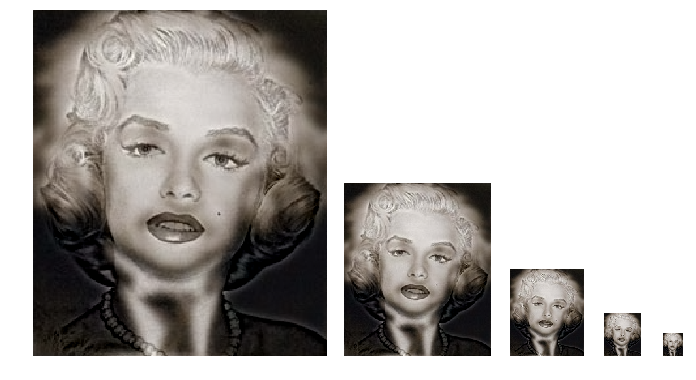

In [12]:
# all variables 

Img_cat = io.imread(r'Images\einstein.bmp')
Img_dog = io.imread(r'Images\marilyn.bmp')
# if you want to check my code works for gray image, remove comment from next two lines.
# Img_cat = skimage.color.rgb2gray(Img_cat) 
# Img_dog = skimage.color.rgb2gray(Img_dog)

# variables for feequency domain filtering
sigma = 0.1
mu = 0

# variables for spatial domain filtering
kernel_lp = np.array([[1,1,1],[1,1,1],[1,1,1]])
kernel_lp = kernel_lp/9
kernel_hp = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

#---------------------------------------------------------------------
# kernal check
# kernel_lp = np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1]])
s11,s22 = kernel_lp.shape
s32,s42 = kernel_hp.shape
if s11 != s32 or s22 != s42:
    print('Kernals are not equal in size')
    sys.exit()

s1,s2 = kernel_lp.shape
if s1 % 2 == 0:
    k1 = 'even'
else:
    k1 = 'odd'
    
if s2 % 2 == 0:
    k2 = 'even'
else:
    k2 = 'odd'
if k1 == 'even' or k2 == 'even':
    print('Kernal size must be odd numbers')
    sys.exit()
#----------------------------------------------------------------------
# switching between filter type, spatial or frequency domain
# switch = 'freq'
# switch = 'spatial'
def filter_switch(i):
    switcher={
            0:'freq',
            1:'spatial'
         }
    return switcher.get(i)
switch = filter_switch(0)
#----------------------------------------------------------------------

hybrid_img2 = HYBRIF_all(Img_cat,Img_dog,sigma,mu,kernel_lp,kernel_hp,switch)

plots(hybrid_img2)

The following cell checks if the input image and hybrid images are equal in shape or impulse response check.

In [13]:
# Impulse response check
hybrid_img2 = HYBRIF_all(Img_cat,Img_dog,sigma,mu,kernel_lp,kernel_hp,switch)
if np.ndim(Img_cat)==3:
    label='color'
elif np.ndim(Img_cat)==2:
    label='gray'
if label == "gray":
    s51,s61 = Img_cat.shape
    s71,s81 = hybrid_img2.shape
elif label == "color":
    s51,s61,pp = Img_cat.shape
    s71,s81,pp = hybrid_img2.shape

if s51 == s71 and s61 == s81:
    print('Input and Output images are in same size. Impulse successful')
    sys.exit()

Input and Output images are in same size. Impulse successful


SystemExit: 

C:\Users\Azam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Question 1

In image processing, a kernel, convolution matrix, or mask is a small matrix. It is used for blurring, sharpening, embossing, edge detection, and more.

<img src="Images/Convolution_schematic.gif" style="width:500px;height:300px;">

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up.

# Question 2

The basic difference between convolution and correlation is that the convolution process rotates the matrix by 180 degrees. Most of the time the choice of using the convolution and correlation is up to the preference of the users, and it is identical when the kernel is symmetrical.

Text(0.5, 1.0, 'correlation')

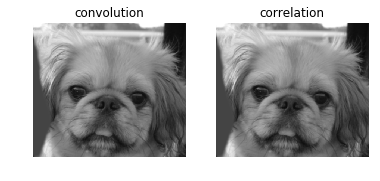

In [14]:
# convolution and correlation comparison

dog = io.imread(r'Images/dog.bmp')
dog = skimage.color.rgb2gray(dog) 
kernel_lp = np.array([[1,1,1],[1,1,1],[1,1,1]])
in2 = kernel_lp/9
test = scipy.signal.convolve2d(dog, in2, mode='same', boundary='fill', fillvalue=0)

test1 = scipy.signal.correlate2d(dog, in2, mode='same', boundary='fill', fillvalue=0)

f, axes = plt.subplots(1,2)
for ax in axes:
    ax.axis('off')
(ax0,ax1) = axes
ax0.imshow(test,cmap='gray')
ax0.set_title('convolution')
ax1.imshow(test1,cmap='gray')
ax1.set_title('correlation')

# Question 3

I generated two Gaussian filters as shown below. One of them are high pass Gaussian and the other one is low pass Gaussian.

Text(0.5, 0.92, 'Low pass Gaussian')

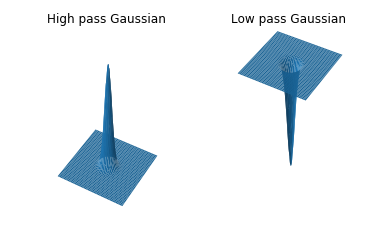

In [15]:
# just plotting Gaussian filters which are used in frequency domain
if np.ndim(Img_cat)==3:
    label='color'
elif np.ndim(Img_cat)==2:
    label='gray'

if label == "gray":
    m,n = Img_cat.shape
elif label == "color":
    m,n,pp = Img_cat.shape
    
x, y = np.meshgrid(np.linspace(-1,1,n), np.linspace(-1,1,m))
g,h = gauss(sigma,mu,m,n)
fig, axes = plt.subplots(1,2)
for ax in axes:
    ax.axis('off')

(ax0,ax1) = axes
ax0=fig.add_subplot(121,projection='3d')
ax1=fig.add_subplot(122,projection='3d')
ax0.plot_surface(x,y,g)
ax1.plot_surface(x,y,h)
ax0.axis('off')
ax1.axis('off')
ax0.set_title('High pass Gaussian')
ax1.set_title('Low pass Gaussian')

# Question 4

The following cell generated a plot in 3D which represents computation time in z axis, and image size and kernel size in x and y axis respectively.

C:\Users\Azam\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


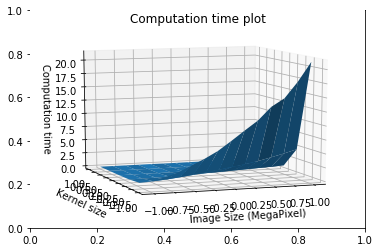

In [205]:
# question 4 

book = io.imread(r'BookShelf.jpg')
book1 = image_resized = resize(book, (book.shape[0] // 2, book.shape[1] // 2),
                       anti_aliasing=True)
book2 = image_resized = resize(book1, (book1.shape[0] // 2, book1.shape[1] // 2),
                       anti_aliasing=True)
book3 = image_resized = resize(book2, (book2.shape[0] // 2, book2.shape[1] // 2),
                       anti_aliasing=True)
book4 = image_resized = resize(book3, (book3.shape[0] // 2, book3.shape[1] // 2),
                       anti_aliasing=True)
book5 = image_resized = resize(book4, (book4.shape[0] // 2, book4.shape[1] // 2),
                       anti_aliasing=True)
bk = [book,book1,book2,book3,book4,book5]


T = np.zeros([6,13])

for k1 in range(6):
    in1 = bk[k1]
    b,g,r = cv2.split(in1)
    inputs = [b,g,r]
    for k2 in range(13):
        in2 = np.random.rand(k2+3,k2+3)
        t1 = time.time()
        for i in range(3):
            in1 = inputs[i]
            in3 = scipy.signal.convolve2d(in1, in2, mode='same', boundary='fill', fillvalue=0)
        t = time.time() - t1
        T[k1,k2] = t
        
        
        
x, y = np.meshgrid(np.linspace(-1,1,13), np.linspace(-1,1,6))
fig, ax0 = plt.subplots(1,1)

ax0=fig.add_subplot(111,projection='3d')
ax0.plot_surface(x,y,T)

ax0.set_title('Computation time plot')
ax0.set_xlabel('Image Size (MegaPixel)')
ax0.set_ylabel('Kernel size')
ax0.set_zlabel('Computation time')
ax0.view_init(10, 250)